A rendre pour le 27 janvier

In [13]:
from scipy.io import loadmat
import numpy as np 
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds, LinearOperator, bicg
from scipy.sparse import diags, csr_matrix
import tqdm

In [14]:
G_path = "data/G.mat"
H_path = "data/H.mat"
x_path =  "data/x.mat"

G = loadmat(G_path)['G'].toarray()
H = loadmat(H_path)['H'].toarray()
x = loadmat(x_path)['x']

# Stocker G et H sous la forme de sparse matrices pour accélérer les calculs
G_sparse = csr_matrix(G)
H_sparse = csr_matrix(H)

print("G shape: ", G_sparse.shape)
print("H shape: ", H_sparse.shape)
print("x shape: ", x.shape)

G shape:  (16200, 8100)
H shape:  (16200, 8100)
x shape:  (8100, 1)


In [15]:
# Construct y, according to model (1) (y = Hx + w), using σ = 1.

y = np.dot(H, x) + np.random.normal(0, 1, H_sparse.shape[0]).reshape(-1, 1)
print("y shape: ", y.shape)

y shape:  (16200, 1)


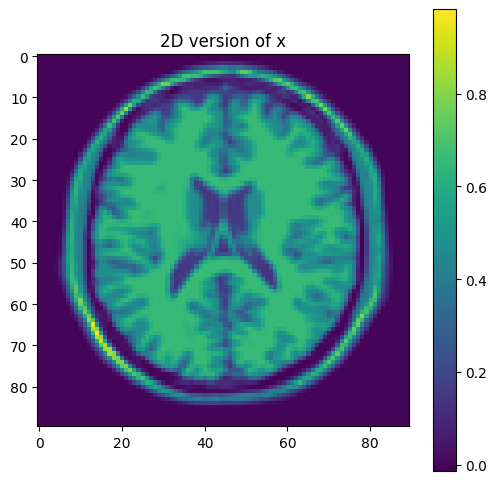

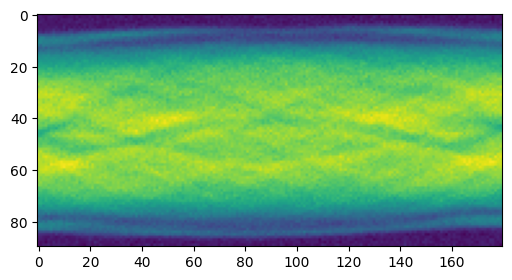

In [16]:
# Here, N = 90 ×  90 pixels and M = 90 ×180 measurements. Display a 2D version of x and a 2D version of y

N = (90, 90)
M = (90, 180)

x_2d = x.reshape(N, order='F')
y_2d = y.reshape(M, order='F')

plt.figure(figsize=(6, 6))
plt.imshow(x_2d)
plt.title('2D version of x')
plt.colorbar()
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(y_2d)
plt.show()

Gradient de $f$ :

$ \nabla f(x) = H^\top (Hx - y) + \lambda  \nabla r(x)$


Avec, 
$\nabla r(x) = \left( \sum_{n=1}^{2N} G_{n,j} \psi'\left([Gx]_n\right) \right)_{j \in \{1, \dots, N\}} = \frac{1}{\delta^2} G^T z$

où $ z = (\frac{[Gx]^{(n)}}{\Psi([Gx]^{(n)})})_{n = 1, ... 2N}$


Conclusion,
$ \nabla f(x) = H^\top (Hx - y) + \lambda  \frac{1}{\delta^2} G^T z$

In [17]:
lambd, delta = 0.13, 0.02

psi = lambda u: np.sqrt(1 + (u/delta)**2)

def psi_prime(u):
    return u/(delta**2*psi(u))

def gradient_f(x):
    Gx = G_sparse@x
    psi_prime = 1/delta**2 * Gx/psi(Gx)
    gradient = H_sparse.T @ H_sparse @ x - H_sparse.T @ y + lambd * G_sparse.T @ psi_prime
    return gradient

def f(x):
    r = np.sum(psi(G_sparse @ x))
    return 1/2*np.linalg.norm(H_sparse @ x - y)**2 + lambd*r

In [18]:
# gradient_f(x)

Soient $x_1$ and $x_2$.

$||\nabla f(x_1) - \nabla f(x_2)|| \leq ||H||^2 |x_1 - x_2| + \frac{\lambda}{\delta^2} |\frac{[Gx_1]^n}{\Psi([Gx_1]^n)} - \frac{[Gx_2]^n}{\Psi([Gx_2]^n)}|$

$||\nabla f(x_1) - \nabla f(x_2)|| \leq ||H||^2 |x_1 - x_2| + \frac{\lambda}{\delta^2} G^TG|x_1 - x_2|$

$||\nabla f(x_1) - \nabla f(x_2)|| \leq (||H||^2 + \frac{\lambda}{\delta^2} ||G||^2) |x_1 - x_2|$

In [19]:
H_norm = svds(H_sparse, k=1)[1][0]
G_norm = svds(G_sparse, k=1)[1][0]

L = H_norm**2 + (lambd / delta**2) * G_norm**2
L

np.float64(18092.773276864806)

In [8]:
x0 = np.zeros((H_sparse.shape[1], 1))
print(x0.shape)

(8100, 1)


In [9]:
def gradient_f_efficace(x, HTH, HTy):
    Gx = G_sparse @ x
    psi_prime = 1/delta**2 * Gx/psi(Gx)
    gradient = HTH @ x - HTy + lambd * G_sparse.T @ psi_prime
    return gradient

def gradient_descent(x0, y, lr=1e-4, max_iter=5000, threshold = 1e-4):
    x = x0.copy()
    HTH = H_sparse.T @ H_sparse
    HTy = H_sparse.T @ y 

    for iter in tqdm.tqdm(range(max_iter)):
        gradient = gradient_f_efficace(x, HTH, HTy)
        x -= lr * gradient
        if np.linalg.norm(gradient) <= threshold:
            break
    return x

x_opt = gradient_descent(x0, y)

100%|██████████| 5000/5000 [02:47<00:00, 29.82it/s]


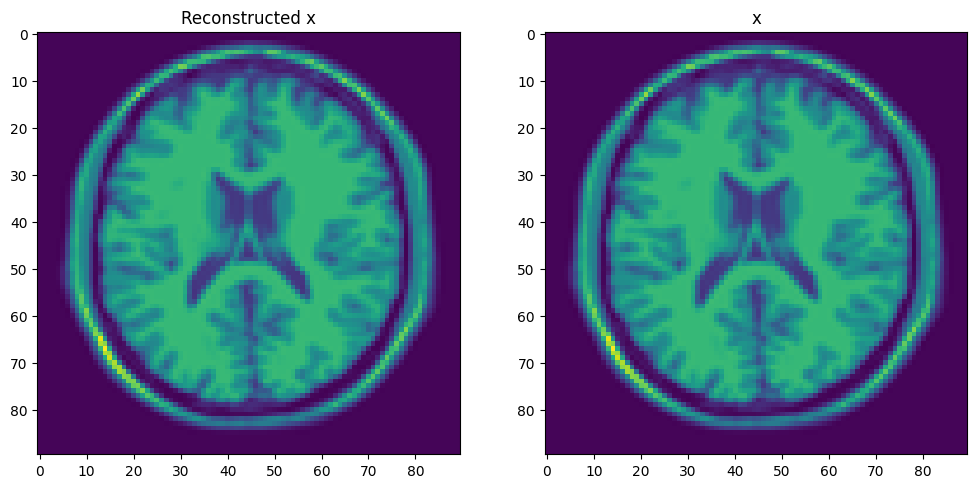

In [10]:
# Visualiser les résultats 
x_opt_2d = x.reshape(N, order='F')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(x_opt_2d)
axes[0].set_title('Reconstructed x')
axes[1].imshow(x_2d)
axes[1].set_title('x')
plt.show()

$A(x) = H^TH + \lambda G^T \Omega(x)G$

Where
$\Omega(x) = \text{Diag}[(w([Gx]^{(n)}))_n]$

and 
$w(u) = \frac{\Psi'(u)}{u}$

In [11]:
# 3.2 MM quadratic algorithm

HTH = H_sparse.T @ H_sparse
HTy = H_sparse.T @ y 

def Omega(Gx):
    omega = 1/(delta**2 * np.sqrt(1 + (Gx/delta)**2))
    return diags(omega.reshape(-1)).tocsc()

def curvature_matrix(Gx):
    Omega_x = Omega(Gx)
    GG_Omega = G_sparse.T @ Omega_x @ G_sparse   
    return HTH + lambd * GG_Omega

def A_op(Gx):
    matvec_op = lambda u : curvature_matrix(Gx) @ u
    return LinearOperator(shape=(H.shape[1], H.shape[1]), matvec=matvec_op, rmatvec=matvec_op)
 
def gradient_f_efficace(x, Gx):
    psi_prime = 1/delta**2 * Gx/psi(Gx)
    gradient = HTH @ x - HTy + lambd * G_sparse.T @ psi_prime
    return gradient

def MM_algo(x0, max_iter=5000, threshold=1e-4):
    x = x0.copy()
    for iter in tqdm.tqdm(range(max_iter)):
        Gx = G_sparse @ x

        grad = gradient_f_efficace(x, Gx)
        variation, _ = bicg(A_op(Gx), -grad)
        
        x += variation.reshape(-1, 1)

        if np.linalg.norm(grad) <= threshold:
            print(f"Algo converged at iter {iter}")
            break
    return x 

In [12]:
x_mm = MM_algo(x0, max_iter=100)

 14%|█▍        | 14/100 [04:33<28:01, 19.55s/it]


KeyboardInterrupt: 

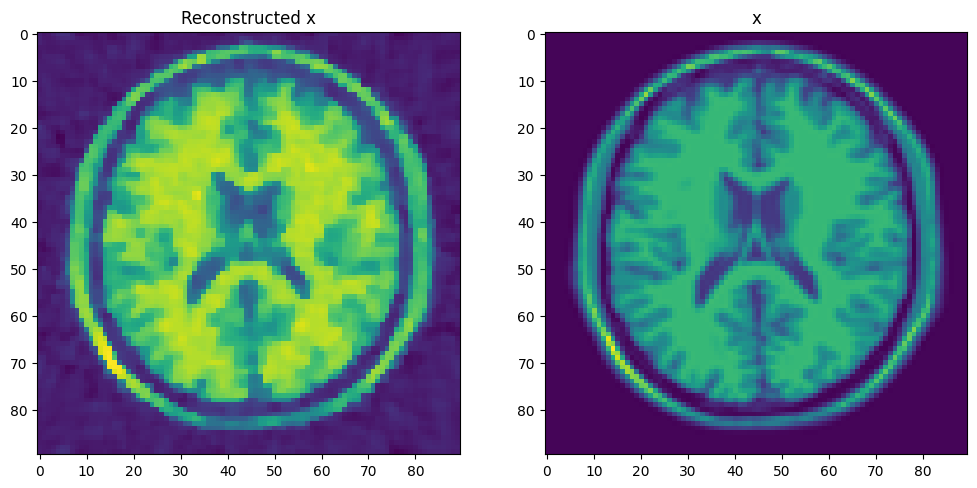

In [25]:
# Visualiser les résultats 
x_mm_2d = x_mm.reshape(N, order='F')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(x_mm_2d)
axes[0].set_title('Reconstructed x')
axes[1].imshow(x_2d)
axes[1].set_title('x')
plt.show()